In [1]:
%%bash
#./extract_vector_vae.py result_0207/

# AutoEncoder で抽出した特徴ベクトルを PCA にかける

### メモ

- attention なしだと累積寄与率が1%程度上昇  
    ただし、attenntion ありの方が分離がうまく行っているように見える…
    
- 第0～2成分までは、タイトルの文字数に対する相関が強い（当然か…）  
    学習もまず文字数から合わせにいっている様子なので
   

### TODO

- unit数を減らして自由度を減らす（文字数に相関の強い成分が多いので）

    -> unit = 50, layer = 2 まで減らすと、文字数への相関を第0成分に
       押し込めることができたように見える

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm # color
from matplotlib.font_manager import FontProperties
import seaborn as sns

import numpy as np
import pandas as pd
import pickle

from sklearn import datasets
from sklearn.decomposition import PCA, KernelPCA

from pprint import pprint

from util_data import test_data

df = test_data('result_0209_C024/vector.pkl', 'data_utanet')
df

,artist,count,lyric,title,vector
0,UNISON SQUARE GARDEN,55,僕は君 に なり たい のに 君 は 僕 に なり たい のに さ / 誰 か の 声 が ...,僕は君になりたい,"[-0.67292, 0.823227, -0.883033, -0.218322, 0.0..."
1,藍坊主,25,やま ない 雨 は なくて ふら ない 雨 も ない / どんなに そう 願って も / 明...,生命のシンバル,"[-1.01878, 0.115035, -0.404805, 0.663965, 0.44..."
2,L'Arc～en～Ciel,30,飽きたり ない んだ ね / 次 は 何 が 欲しい ？ / 罪 の 意識 の ない 飢えた...,HEAVEN'S DRIVE,"[0.177813, 0.653977, -0.408327, 0.0540417, -0...."
3,藍坊主,27,ひっぱる ほど 縮んで ゆく 、 かた 結び の ような 愛 と 、 / 広がる ほど 薄ま...,あさやけのうた,"[-0.716711, 0.144324, 0.309957, 1.34265, -0.10..."
4,flumpool,41,数え きれ ない ほど 何度 も / 君 の 名 を 呼んだ / 何処 か で 微笑んで る...,花になれ,"[-1.21065, 0.277846, 0.37269, 1.2329, -0.29244..."
5,back number,29,生まれ変わって いく んだ 何度 も / 平均 00 点 の 毎日 なら / もっと 自分 ...,泡と羊,"[-0.953511, 0.129496, 0.251883, -1.08659, 0.39..."
6,DOES,15,わかって いる だろ この世 は 天国 / 冷たい 雨 も やがて は 乾く の さ,天国ジャム,"[-0.680719, -1.43465, 0.0582583, 0.0292647, -0..."
7,スガシカオ,23,キイロイ サービス ・ クーポン で / 夢 を つなぐ 強心剤 を ぼく の ウデ に /...,サービス・クーポン,"[0.0209324, -0.0504404, -0.148354, 0.132983, -..."
8,GRANRODEO,32,誇らし さ と 不安 の 入り交じる / 思い で 悟る Don ' t you know ...,メズマライズ,"[-0.396981, 0.5177, 1.18193, 0.535251, -0.3618..."
9,ONE OK ROCK,31,何もかも が 暗く 黒く 見える ! / 色 メガネ 付き の アダルト な パチモン スー...,アダルトスーツ,"[0.4947, 0.342178, 0.245642, -0.0367971, 0.145..."


(1375, 100)
--------------------------------------------------------------------------------


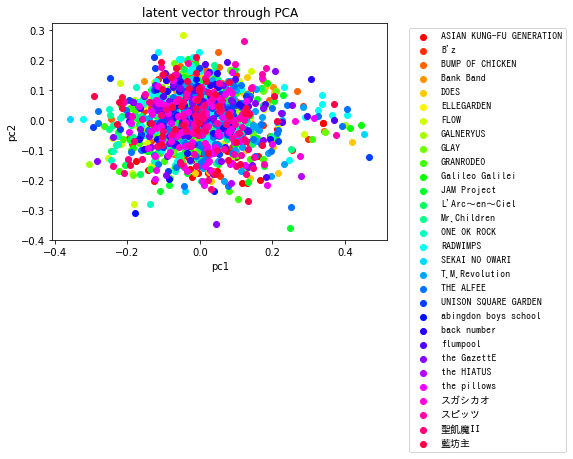

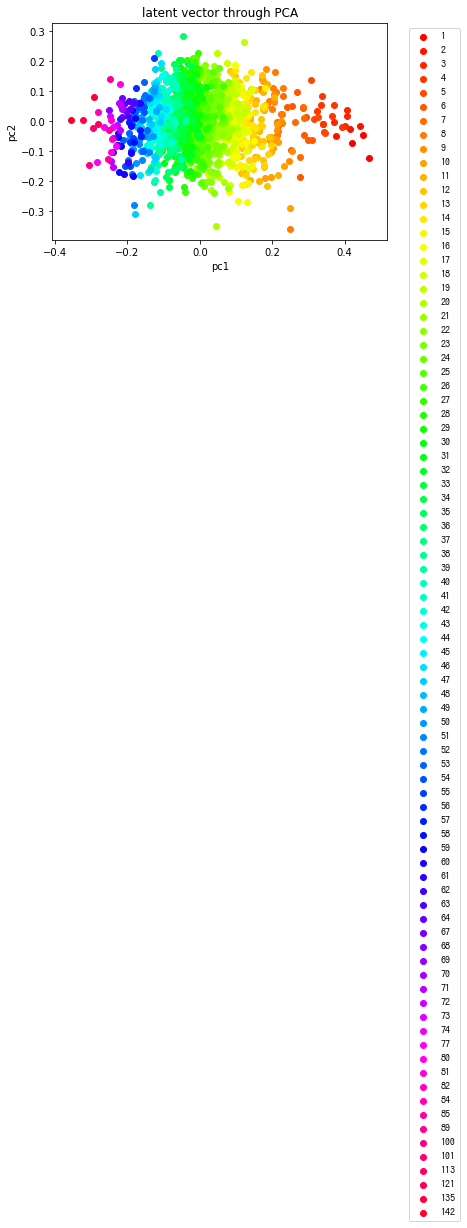

In [94]:

latent = np.array(list(df['vector'])) # numpyに戻す
print(latent.shape)

# 生の latent_vector がガウス分布に正規化されているか確認
#print(latent.mean(axis=0))
#print(np.cov(latent)) # 非対角成分が小さくなるのは確認
# 対角成分が1より小さくなるのはなぜ？ 学習データとテストデータの数の違い？

n = 50 # PCA の次元

print('-' * 80)

# 主成分分析する
# pca = PCA(n_components=n)
# pca.fit(latent)
# pca_latent = pca.fit_transform(latent) # 次元削減
# # 主成分の寄与率を出力する
# print('{0}までの累積寄与率: {1}'.\
#       format(n, sum(pca.explained_variance_ratio_)))


# カーネルPCA
pca = KernelPCA(n_components=n, kernel='rbf')#, gamma=20.0)
pca.fit(latent)
pca_latent = pca.fit_transform(latent) # 次元削減


# Seabort だと xtick の回転のさせ方が分からない
#sns.lmplot('X', 'Y', data=df, row='count') # 線形回帰
#sns.stripplot(x='artist', y='count', data=df) # アーティストごとの単語数の分布

fontfile = '/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf'
fp = FontProperties(fname=fontfile, size=10)

# pc1: latent_vector のインデックス1
# pc2: latent_vector のインデックス2
# hue: なにをラベルにするか
def plot_pca(pc1, pc2, hue='artist'):
    
    df['X'] = pca_latent[:,pc1]
    df['Y'] = pca_latent[:,pc2]

    hue_list = sorted(df[hue].unique())
    
    for i, h in enumerate(hue_list):
        x = df[df[hue] == h]['X'].values
        y = df[df[hue] == h]['Y'].values
        plt.scatter(x, y, color=cm.hsv(float(i/len(hue_list))))
    plt.title('latent vector through PCA')
    plt.xlabel('pc1')
    plt.ylabel('pc2')
    plt.legend(hue_list, prop=fp, loc='upper left', bbox_to_anchor=(1.05,1))
    plt.show()

    
plot_pca(0, 1)
plot_pca(0, 1, hue='count')

